In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
wandb.init(project="model-based-rl-for-control")

W&B Run: https://app.wandb.ai/brunokm/model-based-rl-for-control/runs/15drcxym

In [101]:
import gym
import gym.envs.registration
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pathlib import Path

sns.set()

In [236]:
from cartpole_swingup import CartPoleSwingUp, cartpole_cost_torch
from data import *
from dynamics_models import *
from policy_models import *
from training import *
from utils import *
from evaluation import *
# from model_utils import optimize_policy, learn_policy, train_dynamics_model, cost

In [5]:
figure_dir = Path.home() / 'projects/latex/rl-dissertation/figures'

In [6]:
# Register the custom environment
gym.envs.registration.register(id='CartPoleSwingUp-v0', entry_point='cartpole_swingup:CartPoleSwingUp')

In [9]:
env = gym.make('CartPoleSwingUp-v0')

In [10]:
# env = gym.make('Pendulum-v0')

In [11]:
# Set a random seed
seed = 66
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

### Dynamics Model

In [34]:
obs_noise = 1e-3
dynamics_model = MCDropoutDynamicsNN(input_dim=env.observation_space.shape[0]+env.action_space.shape[0],
                         output_dim=env.observation_space.shape[0],
                         hidden_size=200, drop_prob=0.05)
dynamics_optimizer = torch.optim.Adam(dynamics_model.parameters(), lr=5e-3, weight_decay=1e-4)

### Policy Network

In [42]:
rbf_policy = RBFNetwork(input_size=env.observation_space.shape[0], hidden_size=50, output_size=env.action_space.shape[0], basis_func=gaussian_rbf,
squash_func=lambda x: sin_squash(x, scale=10.0))
policy_optimizer = torch.optim.Adam(rbf_policy.parameters(), lr=1e-3)
# Define a random policy for control
rand_policy = RandomPolicy(env)

### Gather experience

In [24]:
num_steps_in_trial=25
data_buffer = DynamicsDataBuffer(capacity=num_steps_in_trial*10)
states, actions, rewards = rollout(env, rand_policy, num_steps=num_steps_in_trial)
data_buffer.push(*convert_trajectory_to_training(states, actions))
print(data_buffer)

Dynamics Data Buffer with 25 / 250 elements.



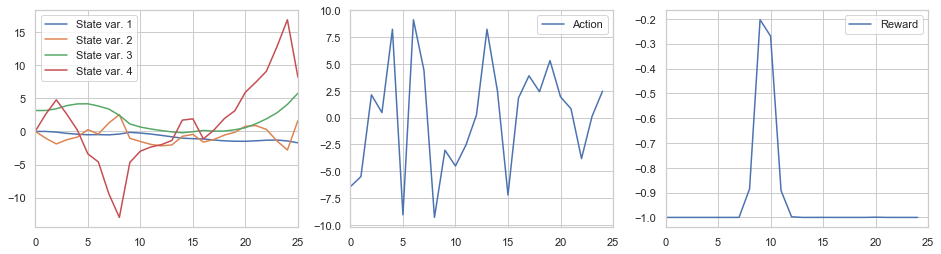

In [25]:
plot_trajectory(states, actions, rewards);

In [26]:
batch_size = 100
scaled_up_dataset = ScaledUpDataset(data_buffer, new_length=int(100*5e3))
dataloader = torch.utils.data.DataLoader(scaled_up_dataset, batch_size=batch_size, shuffle=True)

### First

In [35]:
lr=1e-4; weight_decay=1e-4;
train_mc_dynamics_model(dynamics_model, dataloader, dynamics_optimizer)

Step: 0 	Loss: 3.135852575302124
Step: 100 	Loss: 0.6711599230766296
Step: 200 	Loss: 0.34548741579055786
Step: 300 	Loss: 0.1620035320520401
Step: 400 	Loss: 0.21975263953208923
Step: 500 	Loss: 0.16306918859481812
Step: 600 	Loss: 0.20617303252220154
Step: 700 	Loss: 0.11547598987817764
Step: 800 	Loss: 0.09511568397283554
Step: 900 	Loss: 0.1954898238182068
Step: 1000 	Loss: 0.3205314576625824
Step: 1100 	Loss: 0.14502346515655518
Step: 1200 	Loss: 0.1972844898700714
Step: 1300 	Loss: 0.1353074461221695
Step: 1400 	Loss: 0.13629265129566193
Step: 1500 	Loss: 0.15492048859596252
Step: 1600 	Loss: 0.09578711539506912
Step: 1700 	Loss: 0.08701147139072418
Step: 1800 	Loss: 0.1370934247970581
Step: 1900 	Loss: 0.07029417157173157
Step: 2000 	Loss: 0.22133930027484894
Step: 2100 	Loss: 0.183680921792984
Step: 2200 	Loss: 0.10896819084882736
Step: 2300 	Loss: 0.21069063246250153
Step: 2400 	Loss: 0.11158484220504761
Step: 2500 	Loss: 0.06269750744104385
Step: 2600 	Loss: 0.093613006174564

In [39]:
data_buffer.data[0]

(array([-6.82568218e-03, -2.74748310e-03,  3.14112996e+00,  3.70753089e-02,
        -6.43045282e+00]),
 array([-2.74748310e-04, -1.02910099e+00,  3.70753089e-03,  2.57388812e+00]))

In [40]:
dynamics_model.eval()
dynamics_model.sample_new_mask(1)
dynamics_model(torch.tensor([[-6.82568218e-03, -2.74748310e-03,  3.14112996e+00,  3.70753089e-02,
         -6.43045282e+00]]))

tensor([[-0.0237, -0.9424,  0.0736,  1.7400]], grad_fn=<AddmmBackward>)

In [63]:
# wandb.init(name='policy-training')
rbf_policy = RBFNetwork(input_size=env.observation_space.shape[0], hidden_size=50, output_size=env.action_space.shape[0], basis_func=gaussian_rbf,
squash_func=lambda x: sin_squash(x, scale=10.0))
policy_optimizer = torch.optim.Adam(rbf_policy.parameters(), lr=1e-3)

train_policy(dynamics_model, rbf_policy, policy_optimizer, env, cost_function=cartpole_cost_torch, num_iter=1000, num_time_steps=25, num_particles=10, moment_matching=True)


Step	0	Loss:	24.290332794189453
Step	10	Loss:	24.813844680786133
Step	20	Loss:	24.19123649597168
Step	30	Loss:	24.753128051757812
Step	40	Loss:	24.649307250976562
Step	50	Loss:	24.694992065429688
Step	60	Loss:	24.425865173339844
Step	70	Loss:	24.821063995361328
Step	80	Loss:	24.77430534362793
Step	90	Loss:	24.550750732421875
Step	100	Loss:	24.595958709716797
Step	110	Loss:	24.76190185546875
Step	120	Loss:	24.77013397216797
Step	130	Loss:	24.411876678466797
Step	140	Loss:	24.792156219482422
Step	150	Loss:	24.863418579101562
Step	160	Loss:	23.583600997924805
Step	170	Loss:	24.08837127685547
Step	180	Loss:	24.8098201751709
Step	190	Loss:	24.69549560546875
Step	200	Loss:	24.0582218170166
Step	210	Loss:	23.592092514038086
Step	220	Loss:	24.326635360717773
Step	230	Loss:	23.870271682739258
Step	240	Loss:	24.72541618347168
Step	250	Loss:	23.90973663330078
Step	260	Loss:	24.0897159576416
Step	270	Loss:	23.698535919189453
Step	280	Loss:	23.28654670715332
Step	290	Loss:	23.644084930419922
Step	3

### Do the entire loop with logging

In [ ]:
# Try doing the whole loop
obs_noise = 1e-3
num_steps_in_trial=25
dynamics_batch_size = 100
policy_batch_size = 10
num_policy_iter = 1000
num_dynamics_iter = 5000
num_eval_trajectories = 40
writer = create_summary_writer('runs/deep_pilco')

# Dynamics
dynamics_model = MCDropoutDynamicsNN(input_dim=env.observation_space.shape[0]+env.action_space.shape[0],
                         output_dim=env.observation_space.shape[0],
                         hidden_size=200, drop_prob=0.05, drop_input=True)
dynamics_optimizer = torch.optim.Adam(dynamics_model.parameters(), lr=5e-3, weight_decay=1e-4)
# Policy
rbf_policy = RBFNetwork(input_size=env.observation_space.shape[0], hidden_size=50,
                        output_size=env.action_space.shape[0], basis_func=gaussian_rbf,
                        squash_func=lambda x: sin_squash(x, scale=10.0), output_bias=False)
policy_optimizer = torch.optim.Adam(rbf_policy.parameters(), lr=1e-3)
# Define a random policy for initial experience
rand_policy = RandomPolicy(env)

data_buffer = DynamicsDataBuffer(capacity=num_steps_in_trial*10)
test_data_buffer = DynamicsDataBuffer(capacity=num_steps_in_trial*num_eval_trajectories)
test_dataloader = torch.utils.data.DataLoader(test_data_buffer, batch_size=dynamics_batch_size, shuffle=False)
# Generate eval data for dynamics model:
for _ in range(num_eval_trajectories):
    states, actions, rewards = rollout(env, rand_policy, num_steps=num_steps_in_trial)
    test_data_buffer.push(*convert_trajectory_to_training(states, actions))

# Initial experience:
states, actions, rewards = rollout(env, rbf_policy, num_steps=num_steps_in_trial)
writer.add_figure('sampled trajectory', plot_trajectory(states, actions, rewards)[0], 0)
data_buffer.push(*convert_trajectory_to_training(states, actions))

scaled_up_dataset = ScaledUpDataset(data_buffer, new_length=int(dynamics_batch_size*num_dynamics_iter))
dataloader = torch.utils.data.DataLoader(scaled_up_dataset, batch_size=dynamics_batch_size, shuffle=True)

for i in range(100):
    dynamics_test_loss = eval_mc_dynamics_model(dynamics_model, test_dataloader)
    print(f'DYNAMICS TEST LOSS: {dynamics_test_loss}')
    writer.add_scalar('dynamics validation loss', dynamics_test_loss, i)
    train_mc_dynamics_model(dynamics_model, dataloader, dynamics_optimizer, summary_writer=writer,
                            start_step=i*num_dynamics_iter)
    train_policy(dynamics_model, rbf_policy, policy_optimizer, env, cost_function=cartpole_cost_torch,
                 num_iter=num_policy_iter, num_time_steps=num_steps_in_trial, num_particles=policy_batch_size,
                 moment_matching=False, summary_writer=writer, start_step=i*num_policy_iter)
    # Evaluate the policy
    eval_rewards = eval_policy(env, rbf_policy, num_iter=50, num_steps=num_steps_in_trial)
    writer.add_scalar('eval reward', eval_rewards.mean(), i+1)
    writer.add_histogram('rewards/evaluation', eval_rewards, i+1)
    
    # Gather more experience
    states, actions, rewards = rollout(env, rbf_policy, num_steps=num_steps_in_trial) # TODO put in rbf
    writer.add_figure('sampled trajectory', plot_trajectory(states, actions, rewards)[0], i+1)
    data_buffer.push(*convert_trajectory_to_training(states, actions))
    print(f'Iteration {i} complete')


DYNAMICS TEST LOSS: 2.6002674102783203
Step: 0 	Loss: 1.3519537448883057
Step: 100 	Loss: 0.26645445823669434
Step: 200 	Loss: 0.3435017466545105
Step: 300 	Loss: 0.1877032220363617
Step: 400 	Loss: 0.07066807895898819
Step: 500 	Loss: 0.05416232720017433
Step: 600 	Loss: 0.12473206222057343
Step: 700 	Loss: 0.09159369766712189
Step: 800 	Loss: 0.03186775743961334
Step: 900 	Loss: 0.03295401483774185
Step: 1000 	Loss: 0.051775164902210236
Step: 1100 	Loss: 0.0755196288228035
Step: 1200 	Loss: 0.04016971215605736
Step: 1300 	Loss: 0.031094055622816086
Step: 1400 	Loss: 0.054990898817777634
Step: 1500 	Loss: 0.0936327576637268
Step: 1600 	Loss: 0.04346334934234619
Step: 1700 	Loss: 0.029219456017017365
Step: 1800 	Loss: 0.04028436169028282
Step: 1900 	Loss: 0.04581637680530548
Step: 2000 	Loss: 0.07997940480709076
Step: 2100 	Loss: 0.04718702659010887
Step: 2200 	Loss: 0.052559126168489456
Step: 2300 	Loss: 0.030533507466316223
Step: 2400 	Loss: 0.04466835409402847
Step: 2500 	Loss: 0.03

Step	290	Loss:	24.808835983276367
Step	300	Loss:	24.66597557067871
Step	310	Loss:	23.96283531188965
Step	320	Loss:	24.403133392333984
Step	330	Loss:	24.24980926513672
Step	340	Loss:	24.60379409790039
Step	350	Loss:	24.14828872680664
Step	360	Loss:	24.54960060119629
Step	370	Loss:	24.615936279296875
Step	380	Loss:	24.438886642456055
Step	390	Loss:	24.693485260009766
Step	400	Loss:	24.6258602142334
Step	410	Loss:	24.167856216430664
Step	420	Loss:	24.73429298400879
Step	430	Loss:	24.314281463623047
Step	440	Loss:	24.560075759887695
Step	450	Loss:	24.05801010131836
Step	460	Loss:	24.266508102416992
Step	470	Loss:	24.515249252319336
Step	480	Loss:	24.235734939575195
Step	490	Loss:	24.870914459228516
Step	500	Loss:	24.349828720092773
Step	510	Loss:	24.586816787719727
Step	520	Loss:	24.319557189941406
Step	530	Loss:	24.46970558166504
Step	540	Loss:	24.016212463378906
Step	550	Loss:	24.930042266845703
Step	560	Loss:	24.486072540283203
Step	570	Loss:	24.5970516204834
Step	580	Loss:	24.233642578

Step: 1300 	Loss: 0.21514615416526794
Step: 1400 	Loss: 0.04386109486222267
Step: 1500 	Loss: 0.06946071237325668
Step: 1600 	Loss: 0.03034134954214096
Step: 1700 	Loss: 0.07828213274478912
Step: 1800 	Loss: 0.09155726432800293
Step: 1900 	Loss: 0.07432886958122253
Step: 2000 	Loss: 0.06779806315898895
Step: 2100 	Loss: 0.09896185994148254
Step: 2200 	Loss: 0.08542130142450333
Step: 2300 	Loss: 0.07006587088108063
Step: 2400 	Loss: 0.08266149461269379
Step: 2500 	Loss: 0.045381564646959305
Step: 2600 	Loss: 0.0832807794213295
Step: 2700 	Loss: 0.07132900506258011
Step: 2800 	Loss: 0.07459110021591187
Step: 2900 	Loss: 0.07724703103303909
Step: 3000 	Loss: 0.054217878729104996
Step: 3100 	Loss: 0.07779428362846375
Step: 3200 	Loss: 0.038673870265483856
Step: 3300 	Loss: 0.058349963277578354
Step: 3400 	Loss: 0.10768487304449081
Step: 3500 	Loss: 0.02290845848619938
Step: 3600 	Loss: 0.12381106615066528
Step: 3700 	Loss: 0.09076281636953354
Step: 3800 	Loss: 0.09994176030158997
Step: 390

Step	450	Loss:	22.57208251953125
Step	460	Loss:	23.08574104309082
Step	470	Loss:	23.543733596801758
Step	480	Loss:	23.465848922729492
Step	490	Loss:	23.786941528320312
Step	500	Loss:	23.450103759765625
Step	510	Loss:	23.726110458374023
Step	520	Loss:	23.60682487487793
Step	530	Loss:	22.98662757873535
Step	540	Loss:	23.356098175048828
Step	550	Loss:	23.461483001708984
Step	560	Loss:	23.135488510131836
Step	570	Loss:	23.080076217651367
Step	580	Loss:	23.937101364135742
Step	590	Loss:	22.74124526977539
Step	600	Loss:	24.310401916503906
Step	610	Loss:	24.42641830444336
Step	620	Loss:	23.17429542541504
Step	630	Loss:	24.090620040893555
Step	640	Loss:	23.620330810546875
Step	650	Loss:	22.698041915893555
Step	660	Loss:	23.632556915283203
Step	670	Loss:	23.38315200805664
Step	680	Loss:	23.582822799682617
Step	690	Loss:	23.805788040161133
Step	700	Loss:	23.886425018310547
Step	710	Loss:	22.719921112060547
Step	720	Loss:	23.78822898864746
Step	730	Loss:	22.860790252685547
Step	740	Loss:	24.28416

Step: 2700 	Loss: 0.10519224405288696
Step: 2800 	Loss: 0.07612623274326324
Step: 2900 	Loss: 0.06559500843286514
Step: 3000 	Loss: 0.06576608866453171
Step: 3100 	Loss: 0.11130470037460327
Step: 3200 	Loss: 0.1109778955578804
Step: 3300 	Loss: 0.06200622022151947
Step: 3400 	Loss: 0.07505516707897186
Step: 3500 	Loss: 0.1032625138759613
Step: 3600 	Loss: 0.0852605402469635
Step: 3700 	Loss: 0.10191453993320465
Step: 3800 	Loss: 0.09381887316703796
Step: 3900 	Loss: 0.15682852268218994
Step: 4000 	Loss: 0.18554750084877014
Step: 4100 	Loss: 0.08125391602516174
Step: 4200 	Loss: 0.10413820296525955
Step: 4300 	Loss: 0.09337177127599716
Step: 4400 	Loss: 0.13301806151866913
Step: 4500 	Loss: 0.06774760782718658
Step: 4600 	Loss: 0.10123926401138306
Step: 4700 	Loss: 0.08284283429384232
Step: 4800 	Loss: 0.05533015355467796
Step: 4900 	Loss: 0.10558032244443893
Step	0	Loss:	23.508588790893555
Step	10	Loss:	23.719196319580078
Step	20	Loss:	24.277637481689453
Step	30	Loss:	23.30405426025390

Step	610	Loss:	24.24660301208496
Step	620	Loss:	24.14126205444336
Step	630	Loss:	24.76759910583496
Step	640	Loss:	24.67512321472168
Step	650	Loss:	23.968904495239258
Step	660	Loss:	24.780467987060547
Step	670	Loss:	24.412708282470703
Step	680	Loss:	24.01578140258789
Step	690	Loss:	24.918453216552734
Step	700	Loss:	23.974334716796875
Step	710	Loss:	24.098920822143555
Step	720	Loss:	24.142221450805664
Step	730	Loss:	24.432571411132812
Step	740	Loss:	24.599781036376953
Step	750	Loss:	24.36165428161621
Step	760	Loss:	24.462636947631836
Step	770	Loss:	24.641231536865234
Step	780	Loss:	24.151546478271484
Step	790	Loss:	24.632205963134766
Step	800	Loss:	24.1551456451416
Step	810	Loss:	24.582416534423828
Step	820	Loss:	24.322053909301758
Step	830	Loss:	24.247892379760742
Step	840	Loss:	24.74344825744629
Step	850	Loss:	23.62187957763672
Step	860	Loss:	24.03599739074707
Step	870	Loss:	24.24598503112793
Step	880	Loss:	24.68226432800293
Step	890	Loss:	24.327035903930664
Step	900	Loss:	24.325202941

Step: 4100 	Loss: 0.0833573266863823
Step: 4200 	Loss: 0.0766238421201706
Step: 4300 	Loss: 0.07241109013557434
Step: 4400 	Loss: 0.2022782266139984
Step: 4500 	Loss: 0.13755783438682556
Step: 4600 	Loss: 0.0546598806977272
Step: 4700 	Loss: 0.08494635671377182
Step: 4800 	Loss: 0.07821636646986008
Step: 4900 	Loss: 0.10348019003868103
Step	0	Loss:	23.43794059753418
Step	10	Loss:	23.987953186035156
Step	20	Loss:	24.37479591369629
Step	30	Loss:	24.287403106689453
Step	40	Loss:	23.759017944335938
Step	50	Loss:	24.162988662719727
Step	60	Loss:	24.150249481201172
Step	70	Loss:	24.296024322509766
Step	80	Loss:	23.88871955871582
Step	90	Loss:	23.86209487915039
Step	100	Loss:	24.125226974487305
Step	110	Loss:	22.443296432495117
Step	120	Loss:	24.056062698364258
Step	130	Loss:	23.12952995300293
Step	140	Loss:	23.970563888549805
Step	150	Loss:	23.435483932495117
Step	160	Loss:	24.032621383666992
Step	170	Loss:	22.549049377441406
Step	180	Loss:	23.638288497924805
Step	190	Loss:	23.30147743225097

Step	770	Loss:	24.72563934326172
Step	780	Loss:	24.391006469726562
Step	790	Loss:	24.199369430541992
Step	800	Loss:	24.166013717651367
Step	810	Loss:	24.339330673217773
Step	820	Loss:	24.632949829101562
Step	830	Loss:	24.522878646850586
Step	840	Loss:	24.04928207397461
Step	850	Loss:	24.596759796142578
Step	860	Loss:	23.82484245300293
Step	870	Loss:	24.883691787719727
Step	880	Loss:	24.0832462310791
Step	890	Loss:	24.136306762695312
Step	900	Loss:	24.420047760009766
Step	910	Loss:	24.569101333618164
Step	920	Loss:	23.43209457397461
Step	930	Loss:	24.135190963745117
Step	940	Loss:	24.809511184692383
Step	950	Loss:	24.38724136352539
Step	960	Loss:	24.022705078125
Step	970	Loss:	24.0555477142334
Step	980	Loss:	24.58845329284668
Step	990	Loss:	24.36635971069336
Iteration 10 complete
DYNAMICS TEST LOSS: 1.6397571563720703
Step: 0 	Loss: 0.08091939985752106
Step: 100 	Loss: 0.1630905121564865
Step: 200 	Loss: 0.13692313432693481
Step: 300 	Loss: 0.08355167508125305
Step: 400 	Loss: 0.0714459

Step	60	Loss:	24.373708724975586
Step	70	Loss:	23.61262321472168
Step	80	Loss:	22.634681701660156
Step	90	Loss:	23.24388313293457
Step	100	Loss:	23.623210906982422
Step	110	Loss:	24.253698348999023
Step	120	Loss:	23.050220489501953
Step	130	Loss:	23.10635757446289
Step	140	Loss:	22.818588256835938
Step	150	Loss:	23.579246520996094
Step	160	Loss:	23.91498565673828
Step	170	Loss:	23.510942459106445
Step	180	Loss:	23.23918914794922
Step	190	Loss:	23.54793930053711
Step	200	Loss:	22.439743041992188
Step	210	Loss:	23.835420608520508
Step	220	Loss:	23.859439849853516
Step	230	Loss:	23.75444984436035
Step	240	Loss:	23.438230514526367
Step	250	Loss:	23.39689064025879
Step	260	Loss:	23.567827224731445
Step	270	Loss:	24.26803970336914
Step	280	Loss:	23.794857025146484
Step	290	Loss:	24.017292022705078
Step	300	Loss:	22.880033493041992
Step	310	Loss:	23.063560485839844
Step	320	Loss:	23.967357635498047
Step	330	Loss:	23.95166015625
Step	340	Loss:	22.86963653564453
Step	350	Loss:	24.03748703002929

Step	930	Loss:	21.995250701904297
Step	940	Loss:	21.776552200317383
Step	950	Loss:	22.061277389526367
Step	960	Loss:	22.223312377929688
Step	970	Loss:	21.589189529418945
Step	980	Loss:	21.694623947143555
Step	990	Loss:	22.143522262573242
Iteration 13 complete
DYNAMICS TEST LOSS: 1.674417495727539
Step: 0 	Loss: 0.10193116217851639
Step: 100 	Loss: 0.14413538575172424
Step: 200 	Loss: 0.15384243428707123
Step: 300 	Loss: 0.1013004407286644
Step: 400 	Loss: 0.15032048523426056
Step: 500 	Loss: 0.05799850448966026
Step: 600 	Loss: 0.11350242793560028
Step: 700 	Loss: 0.09077585488557816
Step: 800 	Loss: 0.12185254693031311
Step: 900 	Loss: 0.08418991416692734
Step: 1000 	Loss: 0.08311261981725693
Step: 1100 	Loss: 0.17113006114959717
Step: 1200 	Loss: 0.10482839494943619
Step: 1300 	Loss: 0.11666011810302734
Step: 1400 	Loss: 0.06761696189641953
Step: 1500 	Loss: 0.08138612657785416
Step: 1600 	Loss: 0.09240409731864929
Step: 1700 	Loss: 0.1541588455438614
Step: 1800 	Loss: 0.107370816171

Step	230	Loss:	22.119354248046875
Step	240	Loss:	23.48508644104004
Step	250	Loss:	22.769784927368164
Step	260	Loss:	21.520902633666992
Step	270	Loss:	22.432458877563477
Step	280	Loss:	22.985328674316406
Step	290	Loss:	22.523353576660156
Step	300	Loss:	21.893781661987305
Step	310	Loss:	22.36543846130371
Step	320	Loss:	21.47395896911621
Step	330	Loss:	22.687992095947266
Step	340	Loss:	21.950557708740234
Step	350	Loss:	21.307493209838867
Step	360	Loss:	21.956851959228516
Step	370	Loss:	21.508922576904297
Step	380	Loss:	21.700361251831055
Step	390	Loss:	22.34882354736328
Step	400	Loss:	22.39606475830078
Step	410	Loss:	21.736125946044922
Step	420	Loss:	21.1246337890625
Step	430	Loss:	22.124126434326172
Step	440	Loss:	22.211721420288086
Step	450	Loss:	22.15486717224121
Step	460	Loss:	21.760408401489258
Step	470	Loss:	21.67620849609375
Step	480	Loss:	22.593965530395508
Step	490	Loss:	21.452363967895508
Step	500	Loss:	22.670682907104492
Step	510	Loss:	22.0562744140625
Step	520	Loss:	22.0474777

Step: 800 	Loss: 0.1163824275135994
Step: 900 	Loss: 0.14325709640979767
Step: 1000 	Loss: 0.09578467160463333
Step: 1100 	Loss: 0.12280134856700897
Step: 1200 	Loss: 0.1455935686826706
Step: 1300 	Loss: 0.062027331441640854
Step: 1400 	Loss: 0.14237909018993378
Step: 1500 	Loss: 0.19080576300621033
Step: 1600 	Loss: 0.1718374788761139
Step: 1700 	Loss: 0.1298804134130478
Step: 1800 	Loss: 0.1347511261701584
Step: 1900 	Loss: 0.09627202898263931
Step: 2000 	Loss: 0.12688541412353516
Step: 2100 	Loss: 0.08949622511863708
Step: 2200 	Loss: 0.22284072637557983
Step: 2300 	Loss: 0.1814478635787964
Step: 2400 	Loss: 0.07626423239707947
Step: 2500 	Loss: 0.11792013794183731
Step: 2600 	Loss: 0.16971330344676971
Step: 2700 	Loss: 0.07017659395933151
Step: 2800 	Loss: 0.19366218149662018
Step: 2900 	Loss: 0.11330947279930115
Step: 3000 	Loss: 0.11414620280265808
Step: 3100 	Loss: 0.1582796722650528
Step: 3200 	Loss: 0.09669408947229385
Step: 3300 	Loss: 0.12526622414588928
Step: 3400 	Loss: 0.

Step	400	Loss:	22.63533592224121
Step	410	Loss:	21.42428970336914
Step	420	Loss:	21.820505142211914
Step	430	Loss:	21.1617374420166
Step	440	Loss:	21.989456176757812
Step	450	Loss:	21.94721794128418
Step	460	Loss:	22.606971740722656
Step	470	Loss:	22.909557342529297
Step	480	Loss:	21.88564682006836
Step	490	Loss:	21.703632354736328
Step	500	Loss:	21.318340301513672
Step	510	Loss:	22.418609619140625
Step	520	Loss:	20.964689254760742
Step	530	Loss:	23.0
Step	540	Loss:	22.340200424194336
Step	550	Loss:	21.55913734436035
Step	560	Loss:	22.71196174621582
Step	570	Loss:	21.52737808227539
Step	580	Loss:	22.369922637939453
Step	590	Loss:	21.13522720336914
Step	600	Loss:	22.143957138061523
Step	610	Loss:	22.266435623168945
Step	620	Loss:	22.28863525390625
Step	630	Loss:	22.7308406829834
Step	640	Loss:	21.40243148803711
Step	650	Loss:	21.898157119750977
Step	660	Loss:	21.9601993560791
Step	670	Loss:	21.887372970581055
Step	680	Loss:	20.8249454498291
Step	690	Loss:	21.569271087646484
Step	700	Los

Step: 2400 	Loss: 0.12018393725156784
Step: 2500 	Loss: 0.1243927851319313
Step: 2600 	Loss: 0.11294238269329071
Step: 2700 	Loss: 0.11048366874456406
Step: 2800 	Loss: 0.11743730306625366
Step: 2900 	Loss: 0.11192202568054199
Step: 3000 	Loss: 0.10293368995189667
Step: 3100 	Loss: 0.06816458702087402
Step: 3200 	Loss: 0.08198931813240051
Step: 3300 	Loss: 0.1387912929058075
Step: 3400 	Loss: 0.1184278279542923
Step: 3500 	Loss: 0.1239011287689209
Step: 3600 	Loss: 0.10684184730052948
Step: 3700 	Loss: 0.11304082721471786
Step: 3800 	Loss: 0.06401000171899796
Step: 3900 	Loss: 0.06838551163673401
Step: 4000 	Loss: 0.07977981865406036
Step: 4100 	Loss: 0.11193546652793884
Step: 4200 	Loss: 0.13825945556163788
Step: 4300 	Loss: 0.18037116527557373
Step: 4400 	Loss: 0.1292496919631958
Step: 4500 	Loss: 0.24047967791557312
Step: 4600 	Loss: 0.22165897488594055
Step: 4700 	Loss: 0.0715266540646553
Step: 4800 	Loss: 0.2215910404920578
Step: 4900 	Loss: 0.14083488285541534
Step	0	Loss:	21.603

Step	580	Loss:	21.94952392578125
Step	590	Loss:	20.849777221679688
Step	600	Loss:	21.36800765991211
Step	610	Loss:	21.930845260620117
Step	620	Loss:	21.204042434692383
Step	630	Loss:	17.908802032470703
Step	640	Loss:	19.401735305786133
Step	650	Loss:	20.455856323242188
Step	660	Loss:	21.424570083618164
Step	670	Loss:	21.67982292175293
Step	680	Loss:	21.8420352935791
Step	690	Loss:	20.52823829650879
Step	700	Loss:	21.15833854675293
Step	710	Loss:	21.745868682861328
Step	720	Loss:	20.90108871459961
Step	730	Loss:	21.163555145263672
Step	740	Loss:	20.515655517578125
Step	750	Loss:	20.12384605407715
Step	760	Loss:	22.623111724853516
Step	770	Loss:	21.075027465820312
Step	780	Loss:	20.91107177734375
Step	790	Loss:	20.584566116333008
Step	800	Loss:	20.121217727661133
Step	810	Loss:	21.665542602539062
Step	820	Loss:	21.664165496826172
Step	830	Loss:	20.801410675048828
Step	840	Loss:	20.62692642211914
Step	850	Loss:	22.01082992553711
Step	860	Loss:	19.922767639160156
Step	870	Loss:	21.27966117

Step: 3900 	Loss: 0.14772441983222961
Step: 4000 	Loss: 0.12624627351760864
Step: 4100 	Loss: 0.5040427446365356
Step: 4200 	Loss: 0.2130315601825714
Step: 4300 	Loss: 0.24226851761341095
Step: 4400 	Loss: 0.22704936563968658
Step: 4500 	Loss: 0.09392935782670975
Step: 4600 	Loss: 0.23848873376846313
Step: 4700 	Loss: 0.35382241010665894
Step: 4800 	Loss: 0.21041378378868103
Step: 4900 	Loss: 0.1211041808128357
Step	0	Loss:	21.79442024230957
Step	10	Loss:	21.911727905273438
Step	20	Loss:	22.601354598999023
Step	30	Loss:	23.017860412597656
Step	40	Loss:	22.457441329956055
Step	50	Loss:	22.565336227416992
Step	60	Loss:	22.01682472229004
Step	70	Loss:	22.251678466796875
Step	80	Loss:	21.236682891845703
Step	90	Loss:	22.625904083251953
Step	100	Loss:	22.767202377319336
Step	110	Loss:	22.254127502441406
Step	120	Loss:	20.852943420410156
Step	130	Loss:	23.06291389465332
Step	140	Loss:	22.544275283813477
Step	150	Loss:	22.601335525512695
Step	160	Loss:	21.878583908081055
Step	170	Loss:	22.286

Step	750	Loss:	21.9412784576416
Step	760	Loss:	20.963626861572266
Step	770	Loss:	22.565353393554688
Step	780	Loss:	21.99081802368164
Step	790	Loss:	21.330381393432617
Step	800	Loss:	21.89207649230957
Step	810	Loss:	22.55966567993164
Step	820	Loss:	20.393020629882812
Step	830	Loss:	20.946643829345703
Step	840	Loss:	22.040679931640625
Step	850	Loss:	21.52185821533203
Step	860	Loss:	22.50319480895996
Step	870	Loss:	22.152896881103516
Step	880	Loss:	21.930936813354492
Step	890	Loss:	22.496639251708984
Step	900	Loss:	22.915376663208008
Step	910	Loss:	22.30182456970215
Step	920	Loss:	21.516000747680664
Step	930	Loss:	22.269975662231445
Step	940	Loss:	21.35474395751953
Step	950	Loss:	21.534053802490234
Step	960	Loss:	22.3012638092041
Step	970	Loss:	22.41605567932129
Step	980	Loss:	22.404541015625
Step	990	Loss:	22.423307418823242
Iteration 24 complete
DYNAMICS TEST LOSS: 3.4060120582580566
Step: 0 	Loss: 0.2626308500766754
Step: 100 	Loss: 0.37275445461273193
Step: 200 	Loss: 0.29279896616935

Step	50	Loss:	21.590299606323242
Step	60	Loss:	21.96158218383789
Step	70	Loss:	21.468111038208008
Step	80	Loss:	22.46475601196289
Step	90	Loss:	22.26934814453125
Step	100	Loss:	21.27497673034668
Step	110	Loss:	22.421981811523438
Step	120	Loss:	22.525901794433594
Step	130	Loss:	22.107959747314453
Step	140	Loss:	22.12859344482422
Step	150	Loss:	21.699522018432617
Step	160	Loss:	21.674251556396484
Step	170	Loss:	22.427837371826172
Step	180	Loss:	22.09610939025879
Step	190	Loss:	21.96710968017578
Step	200	Loss:	22.60856819152832
Step	210	Loss:	21.8361759185791
Step	220	Loss:	21.197860717773438
Step	230	Loss:	22.269968032836914
Step	240	Loss:	21.82654571533203
Step	250	Loss:	22.05333709716797
Step	260	Loss:	21.897077560424805
Step	270	Loss:	21.850799560546875
Step	280	Loss:	20.890947341918945
Step	290	Loss:	22.261390686035156
Step	300	Loss:	22.394981384277344
Step	310	Loss:	22.158550262451172
Step	320	Loss:	22.31467628479004
Step	330	Loss:	22.298969268798828
Step	340	Loss:	22.26597785949707

Step	930	Loss:	22.63748550415039
Step	940	Loss:	22.464353561401367
Step	950	Loss:	22.494644165039062
Step	960	Loss:	22.562950134277344
Step	970	Loss:	22.32310676574707
Step	980	Loss:	22.273412704467773
Step	990	Loss:	22.149599075317383
Iteration 27 complete
DYNAMICS TEST LOSS: 2.2586257457733154
Step: 0 	Loss: 0.23046253621578217
Step: 100 	Loss: 0.13830357789993286
Step: 200 	Loss: 0.17218802869319916
Step: 300 	Loss: 0.3116580843925476
Step: 400 	Loss: 0.18073080480098724
Step: 500 	Loss: 0.28418952226638794
Step: 600 	Loss: 0.2633873224258423
Step: 700 	Loss: 0.1483587771654129
Step: 800 	Loss: 0.14178010821342468
Step: 900 	Loss: 0.21414335072040558
Step: 1000 	Loss: 0.30605563521385193
Step: 1100 	Loss: 0.2573259174823761
Step: 1200 	Loss: 0.17694903910160065
Step: 1300 	Loss: 0.20280884206295013
Step: 1400 	Loss: 0.11376286298036575
Step: 1500 	Loss: 0.1617244929075241
Step: 1600 	Loss: 0.2047879993915558
Step: 1700 	Loss: 0.14025874435901642
Step: 1800 	Loss: 0.2039831578731537


Step	230	Loss:	23.545679092407227
Step	240	Loss:	23.159563064575195
Step	250	Loss:	23.02653694152832
Step	260	Loss:	22.99852180480957
Step	270	Loss:	23.009864807128906
Step	280	Loss:	23.171058654785156
Step	290	Loss:	23.478363037109375
Step	300	Loss:	23.87464714050293
Step	310	Loss:	23.84755516052246
Step	320	Loss:	23.618253707885742
Step	330	Loss:	23.50852394104004
Step	340	Loss:	22.855178833007812
Step	350	Loss:	22.956340789794922
Step	360	Loss:	23.224138259887695
Step	370	Loss:	23.497066497802734
Step	380	Loss:	23.233205795288086
Step	390	Loss:	23.001140594482422
Step	400	Loss:	23.592670440673828
Step	410	Loss:	23.18317985534668
Step	420	Loss:	23.630556106567383
Step	430	Loss:	23.031097412109375
Step	440	Loss:	23.226696014404297
Step	450	Loss:	22.77154541015625
Step	460	Loss:	22.953807830810547
Step	470	Loss:	23.35675811767578
Step	480	Loss:	23.189624786376953
Step	490	Loss:	23.0197696685791
Step	500	Loss:	23.36387825012207
Step	510	Loss:	23.466062545776367
Step	520	Loss:	22.8615989

Step: 800 	Loss: 0.1931394338607788
Step: 900 	Loss: 0.1784314662218094
Step: 1000 	Loss: 0.19707340002059937
Step: 1100 	Loss: 0.4473138451576233
Step: 1200 	Loss: 0.3175683617591858
Step: 1300 	Loss: 0.21991902589797974
Step: 1400 	Loss: 0.1900382936000824
Step: 1500 	Loss: 0.19830766320228577
Step: 1600 	Loss: 0.17342399060726166
Step: 1700 	Loss: 0.21425801515579224
Step: 1800 	Loss: 0.17367345094680786
Step: 1900 	Loss: 0.23405706882476807
Step: 2000 	Loss: 0.22869594395160675
Step: 2100 	Loss: 0.36830633878707886
Step: 2200 	Loss: 0.21509750187397003
Step: 2300 	Loss: 0.12638728320598602
Step: 2400 	Loss: 0.13543888926506042
Step: 2500 	Loss: 0.18824085593223572
Step: 2600 	Loss: 0.15483802556991577
Step: 2700 	Loss: 0.31116124987602234
Step: 2800 	Loss: 0.12010408192873001
Step: 2900 	Loss: 0.2372337132692337
Step: 3000 	Loss: 0.2215031087398529
Step: 3100 	Loss: 0.25108620524406433
Step: 3200 	Loss: 0.24545694887638092
Step: 3300 	Loss: 0.393064945936203
Step: 3400 	Loss: 0.287

In [252]:
# Check how good is a 0-model
class ZeroModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x[:, :4]*0
    
    def sample_new_mask(self, batch_size):
        return
    
eval_mc_dynamics_model(ZeroModel(), test_dataloader)

tensor(3.1645)

In [256]:
eval_rewards = eval_policy(env, rbf_policy, num_iter=50, num_steps=num_steps_in_trial)
print(eval_rewards

1.3822752659613598e-06


In [233]:
# Just try to fit a controller
rbf_policy = RBFNetwork(input_size=env.observation_space.shape[0], hidden_size=50, output_size=env.action_space.shape[0], basis_func=gaussian_rbf,
squash_func=lambda x: sin_squash(x, scale=10.0), output_bias=False)
policy_optimizer = torch.optim.Adam(rbf_policy.parameters(), lr=1e-1)

# mlp_policy = nn.Sequential(nn.Linear(4, 200), nn.Sigmoid(), nn.Linear(200, 1), SinSquash(10))
# policy_optimizer = torch.optim.Adam(mlp_policy.parameters(), lr=1e-4)


train_policy(dynamics_model, rbf_policy, policy_optimizer, env, cost_function=cartpole_cost_torch,
                 num_iter=num_policy_iter, num_time_steps=num_steps_in_trial, num_particles=policy_batch_size,
                 moment_matching=True)

Step	0	Loss:	24.999431610107422
Step	10	Loss:	24.203542709350586
Step	20	Loss:	24.425487518310547
Step	30	Loss:	24.529560089111328
Step	40	Loss:	23.448640823364258
Step	50	Loss:	24.731746673583984
Step	60	Loss:	24.2608699798584
Step	70	Loss:	21.546276092529297
Step	80	Loss:	24.52281379699707
Step	90	Loss:	24.92074203491211
Step	100	Loss:	24.511091232299805
Step	110	Loss:	22.038827896118164
Step	120	Loss:	24.059097290039062
Step	130	Loss:	24.592514038085938
Step	140	Loss:	24.65016746520996
Step	150	Loss:	20.030746459960938
Step	160	Loss:	22.115861892700195
Step	170	Loss:	23.540462493896484
Step	180	Loss:	22.890451431274414
Step	190	Loss:	21.31122589111328
Step	200	Loss:	24.77631378173828
Step	210	Loss:	23.07607078552246
Step	220	Loss:	21.807273864746094
Step	230	Loss:	24.317960739135742
Step	240	Loss:	20.00078773498535
Step	250	Loss:	22.125621795654297
Step	260	Loss:	22.783878326416016
Step	270	Loss:	21.092798233032227
Step	280	Loss:	23.91982650756836
Step	290	Loss:	22.165250778198242
S

Step	0	Loss:	24.998498916625977
Step	10	Loss:	24.982084274291992
Step	20	Loss:	24.996110916137695
Step	30	Loss:	24.99894905090332
Step	40	Loss:	24.999723434448242
Step	50	Loss:	24.770801544189453
Step	60	Loss:	24.534997940063477
Step	70	Loss:	23.00832176208496
Step	80	Loss:	24.98387908935547
Step	90	Loss:	24.786758422851562
Step	100	Loss:	24.999271392822266
Step	110	Loss:	24.359325408935547
Step	120	Loss:	24.932100296020508
Step	130	Loss:	24.999122619628906
Step	140	Loss:	24.7855281829834
Step	150	Loss:	24.486520767211914
Step	160	Loss:	24.996192932128906
Step	170	Loss:	24.904077529907227
Step	180	Loss:	24.371578216552734
Step	190	Loss:	24.075342178344727
Step	200	Loss:	24.974254608154297
Step	210	Loss:	24.681020736694336
Step	220	Loss:	24.641136169433594
Step	230	Loss:	24.485553741455078
Step	240	Loss:	24.595767974853516
Step	250	Loss:	24.988502502441406
Step	260	Loss:	24.707408905029297
Step	270	Loss:	24.500476837158203
Step	280	Loss:	24.969694137573242
Step	290	Loss:	24.299028396606

Step	450	Loss:	23.849395751953125
Step	460	Loss:	23.959630966186523
Step	470	Loss:	22.63926124572754
Step	480	Loss:	22.14113426208496
Step	490	Loss:	24.908084869384766
Step	0	Loss:	24.91493797302246
Step	10	Loss:	23.162429809570312
Step	20	Loss:	20.902559280395508
Step	30	Loss:	24.737960815429688
Step	40	Loss:	22.356477737426758
Step	50	Loss:	20.2965145111084
Step	60	Loss:	22.646095275878906
Step	70	Loss:	24.915206909179688
Step	80	Loss:	24.977760314941406
Step	90	Loss:	24.7833251953125
Step	100	Loss:	24.936477661132812
Step	110	Loss:	22.657730102539062
Step	120	Loss:	24.99806022644043
Step	130	Loss:	24.655000686645508
Step	140	Loss:	24.966358184814453
Step	150	Loss:	24.243885040283203
Step	160	Loss:	24.99305534362793
Step	170	Loss:	24.97307777404785
Step	180	Loss:	24.82265281677246
Step	190	Loss:	24.989044189453125
Step	200	Loss:	24.89580535888672
Step	210	Loss:	24.98602294921875
Step	220	Loss:	24.7740535736084
Step	230	Loss:	23.39769172668457
Step	240	Loss:	24.767759323120117
Step	25

Step	410	Loss:	23.049314498901367
Step	420	Loss:	24.95534324645996
Step	430	Loss:	23.87066078186035
Step	440	Loss:	22.054088592529297
Step	450	Loss:	23.916105270385742
Step	460	Loss:	20.694995880126953
Step	470	Loss:	21.841064453125
Step	480	Loss:	23.110055923461914
Step	490	Loss:	23.0574893951416
Step	0	Loss:	24.1972713470459
Step	10	Loss:	24.966894149780273
Step	20	Loss:	24.96156883239746
Step	30	Loss:	24.773283004760742
Step	40	Loss:	22.69487953186035
Step	50	Loss:	24.2825870513916
Step	60	Loss:	23.488407135009766
Step	70	Loss:	23.477209091186523
Step	80	Loss:	23.78321647644043
Step	90	Loss:	21.682424545288086
Step	100	Loss:	23.673364639282227
Step	110	Loss:	23.207490921020508
Step	120	Loss:	22.72874641418457
Step	130	Loss:	23.4317684173584
Step	140	Loss:	21.08682632446289
Step	150	Loss:	21.90654182434082
Step	160	Loss:	23.54951286315918
Step	170	Loss:	24.791215896606445
Step	180	Loss:	24.849802017211914
Step	190	Loss:	23.677541732788086
Step	200	Loss:	22.277490615844727
Step	210	Lo

Step	370	Loss:	24.630952835083008
Step	380	Loss:	24.533681869506836
Step	390	Loss:	24.998798370361328
Step	400	Loss:	24.80242919921875
Step	410	Loss:	24.327741622924805
Step	420	Loss:	24.86838150024414
Step	430	Loss:	24.872886657714844
Step	440	Loss:	24.096036911010742
Step	450	Loss:	23.644241333007812
Step	460	Loss:	23.588266372680664
Step	470	Loss:	24.473894119262695
Step	480	Loss:	21.464069366455078
Step	490	Loss:	24.5093994140625
Step	0	Loss:	24.62110710144043
Step	10	Loss:	23.548988342285156
Step	20	Loss:	24.347017288208008
Step	30	Loss:	24.86212730407715
Step	40	Loss:	24.98784828186035
Step	50	Loss:	22.96644401550293
Step	60	Loss:	24.674278259277344
Step	70	Loss:	24.54119873046875
Step	80	Loss:	24.386106491088867
Step	90	Loss:	24.998985290527344
Step	100	Loss:	24.173851013183594
Step	110	Loss:	22.49542999267578
Step	120	Loss:	24.93814468383789
Step	130	Loss:	23.813695907592773
Step	140	Loss:	24.302547454833984
Step	150	Loss:	24.99825096130371
Step	160	Loss:	24.27567481994629
Step

Step	330	Loss:	22.911296844482422
Step	340	Loss:	22.91875648498535
Step	350	Loss:	24.61100196838379
Step	360	Loss:	23.289098739624023
Step	370	Loss:	23.1882266998291
Step	380	Loss:	22.894678115844727
Step	390	Loss:	24.0450382232666
Step	400	Loss:	22.606721878051758
Step	410	Loss:	24.05341339111328
Step	420	Loss:	23.480432510375977
Step	430	Loss:	23.776073455810547
Step	440	Loss:	23.038692474365234
Step	450	Loss:	23.525230407714844
Step	460	Loss:	24.47988510131836
Step	470	Loss:	23.908029556274414
Step	480	Loss:	24.268033981323242
Step	490	Loss:	23.616559982299805
Step	0	Loss:	24.653732299804688
Step	10	Loss:	24.97435760498047
Step	20	Loss:	24.217227935791016
Step	30	Loss:	24.89807891845703
Step	40	Loss:	24.982250213623047
Step	50	Loss:	24.996776580810547
Step	60	Loss:	24.724916458129883
Step	70	Loss:	24.73965072631836
Step	80	Loss:	24.73021125793457
Step	90	Loss:	24.619449615478516
Step	100	Loss:	24.87082862854004
Step	110	Loss:	24.8095703125
Step	120	Loss:	24.983333587646484
Step	130	

Step	290	Loss:	23.845876693725586
Step	300	Loss:	24.12653923034668
Step	310	Loss:	24.533985137939453
Step	320	Loss:	23.697378158569336
Step	330	Loss:	23.244125366210938
Step	340	Loss:	24.105274200439453
Step	350	Loss:	23.421178817749023
Step	360	Loss:	23.224674224853516
Step	370	Loss:	24.906139373779297
Step	380	Loss:	24.86286735534668
Step	390	Loss:	24.072622299194336
Step	400	Loss:	24.566810607910156
Step	410	Loss:	23.133420944213867
Step	420	Loss:	22.75727653503418
Step	430	Loss:	24.873455047607422
Step	440	Loss:	24.328855514526367
Step	450	Loss:	23.84819793701172
Step	460	Loss:	23.16033172607422
Step	470	Loss:	23.590635299682617
Step	480	Loss:	23.93101692199707
Step	490	Loss:	23.563806533813477
Step	0	Loss:	24.200000762939453
Step	10	Loss:	24.4345645904541
Step	20	Loss:	24.95233917236328
Step	30	Loss:	24.998397827148438
Step	40	Loss:	24.97232437133789
Step	50	Loss:	24.999773025512695
Step	60	Loss:	24.618873596191406
Step	70	Loss:	24.938581466674805
Step	80	Loss:	24.99694061279297
S

Step	250	Loss:	22.721193313598633
Step	260	Loss:	24.38762855529785
Step	270	Loss:	24.99966812133789
Step	280	Loss:	24.24642562866211
Step	290	Loss:	24.994182586669922
Step	300	Loss:	24.412199020385742
Step	310	Loss:	24.99974822998047
Step	320	Loss:	24.37734603881836
Step	330	Loss:	24.237808227539062
Step	340	Loss:	24.179378509521484
Step	350	Loss:	23.423824310302734
Step	360	Loss:	24.99925994873047
Step	370	Loss:	24.999698638916016
Step	380	Loss:	24.114910125732422
Step	390	Loss:	24.534391403198242
Step	400	Loss:	24.996885299682617
Step	410	Loss:	24.790754318237305
Step	420	Loss:	24.72484016418457
Step	430	Loss:	24.99976921081543
Step	440	Loss:	24.853628158569336
Step	450	Loss:	24.035425186157227
Step	460	Loss:	24.727161407470703
Step	470	Loss:	24.99830436706543
Step	480	Loss:	23.929601669311523
Step	490	Loss:	24.99872398376465
Step	0	Loss:	24.784000396728516
Step	10	Loss:	24.973608016967773
Step	20	Loss:	24.98639678955078
Step	30	Loss:	24.727874755859375
Step	40	Loss:	24.9285259246826

Step	220	Loss:	24.917020797729492
Step	230	Loss:	24.43201446533203
Step	240	Loss:	24.805809020996094
Step	250	Loss:	24.596036911010742
Step	260	Loss:	24.56768035888672
Step	270	Loss:	24.631023406982422
Step	280	Loss:	24.657989501953125
Step	290	Loss:	24.943763732910156
Step	300	Loss:	23.37217903137207
Step	310	Loss:	24.937358856201172
Step	320	Loss:	24.19427490234375
Step	330	Loss:	24.161962509155273
Step	340	Loss:	24.819520950317383
Step	350	Loss:	24.015697479248047
Step	360	Loss:	24.536672592163086
Step	370	Loss:	23.893571853637695
Step	380	Loss:	24.89553451538086
Step	390	Loss:	24.778587341308594
Step	400	Loss:	24.27577018737793
Step	410	Loss:	24.16585350036621
Step	420	Loss:	24.166444778442383
Step	430	Loss:	24.99955177307129
Step	440	Loss:	24.999435424804688
Step	450	Loss:	24.477338790893555
Step	460	Loss:	24.888744354248047
Step	470	Loss:	24.998750686645508
Step	480	Loss:	24.247661590576172
Step	490	Loss:	24.75893783569336
Step	0	Loss:	24.919395446777344
Step	10	Loss:	24.81086540

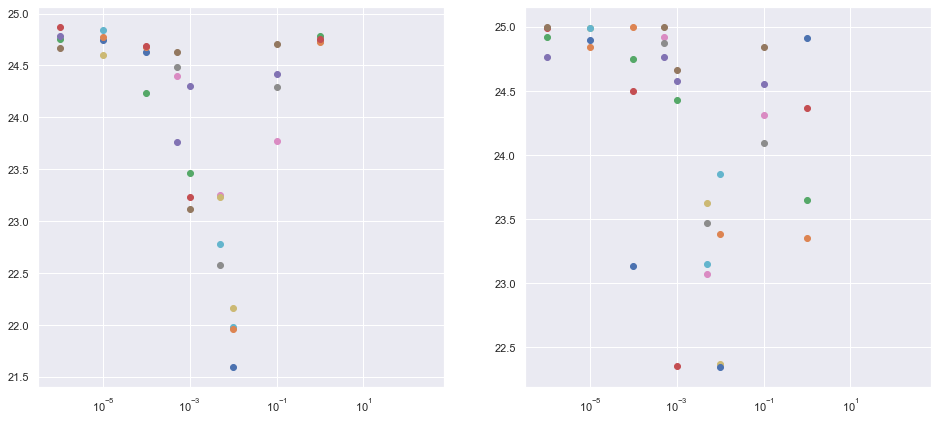

In [240]:
# Uber-quick param search:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
ax[0].set_xscale('log')
ax[1].set_xscale('log')

for lr in [1, 1e-1, 1e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 1e-6]:
    for _ in range(4):
        rbf_policy = RBFNetwork(input_size=env.observation_space.shape[0], hidden_size=50, output_size=env.action_space.shape[0], basis_func=gaussian_rbf,
        squash_func=lambda x: sin_squash(x, scale=10.0), output_bias=False)
        policy_optimizer = torch.optim.Adam(rbf_policy.parameters(), lr=lr)

        # mlp_policy = nn.Sequential(nn.Linear(4, 200), nn.Sigmoid(), nn.Linear(200, 1), SinSquash(10))
        # policy_optimizer = torch.optim.Adam(mlp_policy.parameters(), lr=1e-4)

        train_policy(dynamics_model, rbf_policy, policy_optimizer, env, cost_function=cartpole_cost_torch,
                         num_iter=500, num_time_steps=num_steps_in_trial, num_particles=policy_batch_size,
                         moment_matching=True)
        final_cost = eval_policy_on_model(env, rbf_policy, dynamics_model, cost_function=cartpole_cost_torch,
                                          num_particles=200, num_steps=25, discount_factor=1.0, moment_matching=False)
        final_cost_mm = eval_policy_on_model(env, rbf_policy, dynamics_model, cost_function=cartpole_cost_torch,
                                          num_particles=10, num_steps=25, discount_factor=1.0, moment_matching=True)
        ax[0].scatter(lr, final_cost.data.numpy())
        ax[1].scatter(lr, final_cost_mm.data.numpy())
        

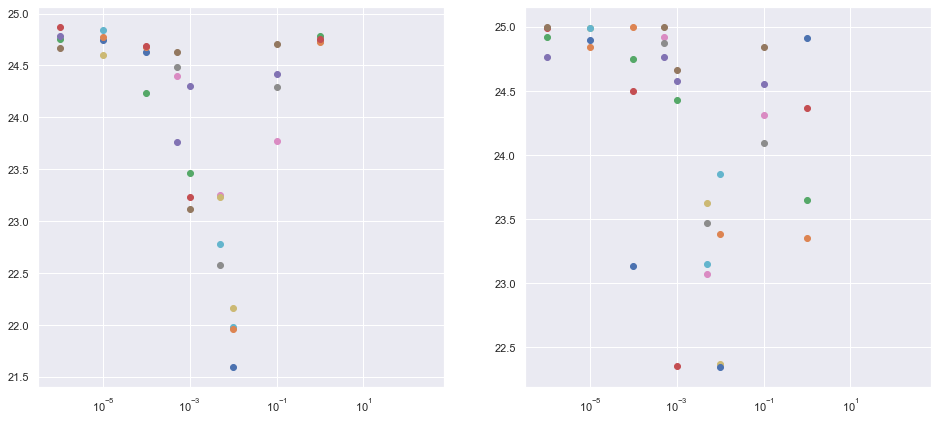

In [250]:

fig

In [229]:
rbf_policy.rbf_layer(torch.tensor([[-0.03285122,  0.13975082,  3.12736639, -0.44875435]])).max()

tensor(0.6099, grad_fn=<MaxBackward1>)

In [218]:
rbf_policy.linear_layer.bias

Parameter containing:
tensor([-0.1219], requires_grad=True)

In [ ]:
observation = env.reset()
for i_episode in range(20):
    observation = env.reset()
    for t in range(20):
        env.render()
        # print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        time.sleep(0.08)
env.close()

In [135]:
data_buffer.data

[(array([-2.75326776e-02, -5.31853927e-02,  3.12747769e+00, -1.11296132e-03,
          1.25264835e+00]),
  array([-5.31853927e-03,  1.92936209e-01, -1.11296132e-04, -4.47641391e-01])),
 (array([-0.03285122,  0.13975082,  3.12736639, -0.44875435,  1.2543875 ]),
  array([ 0.01397508,  0.18999318, -0.04487544, -0.4400106 ])),
 (array([-0.01887614,  0.329744  ,  3.08249096, -0.88876495,  1.26966071]),
  array([ 0.0329744 ,  0.16166991, -0.0888765 , -0.25845889])),
 (array([ 0.01409826,  0.49141391,  2.99361446, -1.14722384,  1.2780596 ]),
  array([ 0.04914139,  0.10468291, -0.11472238,  0.10311494])),
 (array([ 0.06323966,  0.59609682,  2.87889208, -1.0441089 ,  1.2695986 ]),
  array([ 0.05960968,  0.03752572, -0.10441089,  0.54694178])),
 (array([ 0.12284934,  0.63362254,  2.77448119, -0.49716712,  1.23240411]),
  array([ 0.06336225, -0.01157305, -0.04971671,  0.90815552])),
 (array([0.18621159, 0.62204949, 2.72476448, 0.4109884 , 1.21244478]),
  array([ 0.06220495, -0.03252427,  0.041098

In [20]:
obs_noise = 1e-3
# Dynamics
dynamics_model = MCDropoutDynamicsNN(input_dim=env.observation_space.shape[0]+env.action_space.shape[0],
                         output_dim=env.observation_space.shape[0],
                         hidden_size=200, drop_prob=0.05)
dynamics_optimizer = torch.optim.Adam(dynamics_model.parameters(), lr=5e-4, weight_decay=1e-4)
# Policy

In [21]:
rand_policy = RandomPolicy(env)
data_buffer = DynamicsDataBuffer(capacity=num_steps_in_trial*10)

In [22]:
num_steps_in_trial=25
for _ in range(1):
    states, actions, rewards = rollout(env, rand_policy, num_steps=num_steps_in_trial)
    data_buffer.push(*convert_trajectory_to_training(states, actions))

ValueError: all input arrays must have the same shape

In [61]:
scaled_up_dataset = ScaledUpDataset(data_buffer, new_length=int(100*5e4))
dataloader = torch.utils.data.DataLoader(scaled_up_dataset, batch_size=100, shuffle=True)

In [62]:
train_dynamics_model(dynamics_model, dataloader, dynamics_optimizer)

Step	0	Loss:	3.560161828994751
Step	1000	Loss:	2.6809520721435547
Step	2000	Loss:	2.218724012374878
Step	3000	Loss:	2.747805595397949
Step	4000	Loss:	2.894061326980591
Step	5000	Loss:	3.082554578781128
Step	6000	Loss:	3.2707886695861816
Step	7000	Loss:	2.2676384449005127
Step	8000	Loss:	2.833247661590576
Step	9000	Loss:	2.9609780311584473
Step	10000	Loss:	2.6652731895446777
Step	11000	Loss:	2.6245696544647217


KeyboardInterrupt: 

In [1]:

# for i_episode in range(10):
observation = env.reset()
for t in range(100):
    env.render()
    # print(observation)
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

NameError: name 'env' is not defined

In [27]:
observation = env.reset()

In [121]:
observation = env.reset()
while True:
    action = execute_torch_policy(observation, rbf_policy)
    observation, reward, done, info = env.step(action)
    print(observation, action, done)
    time.sleep(0.3)
    env.render()

[ 0.02034258 -0.02347203  3.16754232 -0.06630177] [0.04490909] False
[ 1.79953791e-02 -1.12811433e-03  3.16091215e+00 -1.85842025e-01] [0.04182478] False
[ 0.01788257  0.0165596   3.14232794 -0.27747947] [0.03923377] False
[ 0.01953853  0.02274765  3.11458    -0.29475472] [0.03761506] False
[ 0.02181329  0.01210933  3.08510452 -0.20186062] [0.0355339] False
[ 0.02302423 -0.01598543  3.06491846  0.00686886] [0.03320326] False
[ 0.02142568 -0.05465096  3.06560535  0.29129946] [0.03713903] False
[ 0.01596059 -0.08972496  3.0947353   0.56510078] [0.05427805] False
[ 0.00698809 -0.10398065  3.15124537  0.71569363] [0.07635557] False
[-0.00340997 -0.08224686  3.22281474  0.63766462] [0.08916017] False
[-0.01163466 -0.01871197  3.2865812   0.28016998] [0.08770163] False
[-0.01350586  0.07617239  3.3145982  -0.30925308] [0.07041336] False
[-0.00588862  0.18247044  3.28367289 -0.99364414] [0.05686671] False
[ 0.01235843  0.27765189  3.18430847 -1.57683466] [0.08311924] False
[ 0.04012362  0.318

KeyboardInterrupt: 

In [122]:
env.close()